In [13]:
!ls ../../Data/Weather/

Joined_smoothed_PRCP.parquet STAT_NY.pickle
NY.parquet                   Weather_Stations.tgz
NY.tgz                       stations.parquet


In [1]:
import ipyleaflet
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

## Visualizing the distribution coefficients on a map

## Loading libraries and information

### Load the required libraries

In [3]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math

In [4]:
import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStatistics.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [5]:
import numpy as np
from lib.numpy_pack import packArray,unpackArray
from lib.spark_PCA import computeCov
from lib.computeStatistics import *

###  Load stations information

In [6]:
data_dir='../../Data/Weather/'
!du -sh $data_dir/*

 31M	../../Data/Weather//Joined_smoothed_PRCP.parquet
 76M	../../Data/Weather//NY.parquet
 64M	../../Data/Weather//NY.tgz
 49M	../../Data/Weather//STAT_NY.pickle
348K	../../Data/Weather//Weather_Stations.tgz
416K	../../Data/Weather//stations.parquet


In [7]:
stations_df=sqlContext.read.parquet(data_dir+'/stations.parquet')
stations_df.show(3)

+-----------+----------+--------+---------+---------+-----+----------------+
|    Station|Dist_coast|Latitude|Longitude|Elevation|State|            Name|
+-----------+----------+--------+---------+---------+-----+----------------+
|USC00341900|   739.956|    36.3| -96.4667|    242.3|   OK|       CLEVELAND|
|USC00428114|    908.22|    40.1|-111.6667|   1409.1|   UT|SPANISH FORK 1 S|
|USC00165926|   23.8801| 29.7853| -90.1158|      0.9|   LA|   MARRERO 9 SSW|
+-----------+----------+--------+---------+---------+-----+----------------+
only showing top 3 rows



### Load the reconstructions DataFrame

For details about the columns in this DataFrame see the README notebook

In [14]:
### Read the data frame from a parquet file.

state='NY'
meas='SNWD'

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(state,meas)

df=sqlContext.read.parquet(filename)
print(df.count())
df.show(1)

8026
+-----------+-----------+--------------------+----+-------------------+--------------------+------------------+--------------------+--------------------+------------------+------------------+------------------+------------------+------------------+-------------------+---------+----------+--------+---------+---------+-----+--------------+
|    Station|Measurement|              Values|Year|            coeff_1|             coeff_2|           coeff_3|             coeff_4|             coeff_5|             res_1|             res_2|             res_3|             res_4|             res_5|           res_mean|total_var|Dist_coast|Latitude|Longitude|Elevation|State|          Name|
+-----------+-----------+--------------------+----+-------------------+--------------------+------------------+--------------------+--------------------+------------------+------------------+------------------+------------------+------------------+-------------------+---------+----------+--------+---------+-------

## Compute the count and average of `coef_1` for each station.

In [15]:
#extract longitude and latitude for each station
feature='coeff_1'
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT station, latitude,longitude,elevation,Dist_coast,%s FROM weather"%feature
print(Query)
df1 = sqlContext.sql(Query)

df2=df1.groupby(['station','latitude','longitude','elevation','Dist_coast']).agg({"station": "count", feature: "mean"})
#df2=df1.groupby(['station']).agg({"station": "count", feature: "mean"})
pdf=df2.toPandas()
pdf.sort_values(by=['station'],inplace=True)
pdf.head(5)

SELECT station, latitude,longitude,elevation,Dist_coast,coeff_1 FROM weather


,station,latitude,longitude,elevation,Dist_coast,count(station),avg(coeff_1)
170,USC00300015,43.900002,-76.066704,121.900002,376.802002,25,1518.218186
36,USC00300023,42.101398,-77.234398,304.500000,296.167999,43,-85.428431
275,USC00300047,42.646099,-73.747200,0.000000,166.001007,4,-151.450907
165,USC00300055,43.272202,-78.166397,134.100006,436.303009,28,31.967577
237,USC00300063,42.469700,-73.926697,185.000000,152.889999,4,-21.798765


In [16]:
# Find long/lat bounding box
max_long=pdf['longitude'].max()
min_long=pdf['longitude'].min()
max_lat=pdf['latitude'].max()
min_lat=pdf['latitude'].min()


In [17]:
#define a mapping from the range of the value to hex colors.
from matplotlib.colors import rgb2hex
_avg='avg(%s)'%feature
_min=pdf[_avg].min()
_max=pdf[_avg].max()
_min,_max

import pylab as plt
cmap=plt.get_cmap('jet')
def get_color(val):
    x=(val-_min)/(_max-_min)
    return(rgb2hex(cmap(x)[:3]))


## Map
* Each circle is centered at a station.  
* The area of the circle corresponds to the number of years SNWD was recorded at the station.  
* The color fill of the circle corresponds to the value of `avg(coeff_1)` defined by color-bar.

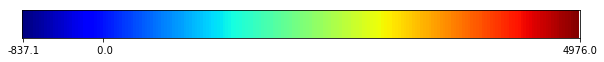

In [18]:
#def color_bar(_min,_max)
import pylab as plt
from matplotlib.pyplot import xticks,yticks
figure(figsize=[10,1])
ax = plt.subplot(111)
vals=cmap(np.arange(0,1,0.005))[:,:3]
vals3=np.stack([vals]*10)
vals3.shape
ax.imshow(vals3);

midpoint=200.*-_min/(_max-_min)
xticks((0,midpoint,200),["%4.1f"%v for v in (_min,0.,_max)])
yticks(());


In [19]:
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 6

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
for index,row in pdf.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count(station)']
    _coef=row[_avg]
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(1200*np.sqrt(_count+0.0)), weight=1,
            color='#F00', opacity=0.8, fill_opacity=0.4,
            fill_color=get_color(_coef))
    circles.append(c)
    m.add_layer(c)
m    

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map data (c) <a href="https://openstreetmap.org">OpenStreetMap</a> contributors'}, center=[42.759552001953125, -75.94625091552734], layers=(TileLayer(base=True, max_zoom=19, min_zoom=1, options=['attribution', 'detect_retina', 'max_zoom', 'min_zoom', 'tile_size']), Rectangle(bounds=[[40.5833, -79.5856], [44.9358, -72.3069]], fill_opacity=0.0, options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'no_clip', 'opacity', 'pointer_events', 'smooth_factor', 'stroke', 'weight']), Circle(color='#F00', fill_color='#2cffca', fill_opacity=0.4, location=[43.900001525878906, -76.06670379638672], opacity=0.8, options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'stroke', 'weight'], radius=6000, weight=1), Circle(color='#F00', fill_color='#0004ff', fill_opacity=0.4, location=[42.10139846801758, -77.2343978881836], opacity=0.8, options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'stroke', 'weight'], radius=7868, weight=1), Circle(color='#F00', fill_color='#0000ff', fill_opacity=0.4, location=[42.64609909057617, -73.74720001220703], opacity=0.8, options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'stroke', 'weight'], radius=2400, weight=1), Circle(color='#F00', fill_color='#0018ff', fill_opacity=0.4, location=[43.27220153808594, -78.16639709472656], opacity=0.8, options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'stroke', 'weight'], radius=6349, weight=1), Circle(color='#F00', fill_color='#000cff', fill_opacity=0.4, location=[42.46969985961914, -73.92669677734375], opacity=0.8, options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'stroke', 'weight'], radius=2400, weight=1), Circle(color='#F00', fill_color='#0040ff', fill_opacity=0.4, location=[44.33330154418945, -75.91670227050781], opacity=0.8, options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'stroke', 'weight'], radius=6893, weight=1), Circle(color='#F00', fill_color='#002cff', fill_opacity=0.4, location=[42.249698638916016, -77.75830078125], opacity=0.8, options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'stroke', 'weight'], radius=9748, weight=1), Circle(color='#F00', fill_color='#0000ed', fill_opacity=0.4, location=[42.099998474121094, -78.56670379638672], opacity=0.8, options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'stroke', 'weight'], radius=2683, weight=1), Circle(color='#F00', fill_color='#0030ff', fill_opacity=0.4, location=[42.10029983520508, -78.74970245361328], opacity=0.8, options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'stroke', 'weight'], radius=10039, weight=1), Circle(color='#F00', fill_color='#003cff', fill_opacity=0.4, location=[42.91669845581055, -74.13330078125], opacity=0.8, options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'stroke', 'weight'], radius=5366, weight=1), Circle(color='#F00', fill_color='#0020ff', fill_opacity=0.4, location=[42.31169891357422, -78.02439880371094], opacity=0.8, options=['class_name', 'cli

### Something to try
* Leaflet supports a variety of maps. See if you can get a topographical map as the background.

### Is coef_1 related to elevation ?

In [ ]:
pdf.plot.scatter(x='elevation',y='avg(coeff_1)',figsize=(8,6));
grid()
xlim([-100,1000])

## Summary
* We saw how to use `ipyLeaflet` to present data on top of maps.
* We saw that in NY state, most of the snow accumulation is in the Adirondacks.
* Snow accumulation increases with elevation, but the relationship is weak: locations with elevation 400-600 meters have widely varying accumulations of snow.

## See you next time